# Given the stock information of at least the past 5 days of all companies, try to predict the closing price of one company on a particular day

# some companies in training set and some companies only in test set

# Load libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error

# Load training set and process Date

In [51]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Check for NaT values after conversion
if data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(data[data['Date'].isnull()])

C:\Users\Admin\AppData\Local\Temp\ipykernel_26308\4089226232.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")


# Training set= companies belonging in the same industry as target company, but excluding target company (test set)
# Define your company of interest and obtain the average closing price for the days in training set (n>= 5)

In [52]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
target_company = 'MMM'

# Ensure we have data for the target company
if target_company not in data['Symbol'].unique():
    raise ValueError(f"{target_company} is not in the dataset.")

# Filter data for the target company
target_data = data[data['Symbol'] == target_company].set_index('Date')

# Ensure we have enough data for the target company
if len(target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# Get the industry of the target company
target_industry = target_data['GICS Sector'].iloc[0]

# Filter data for companies in the same industry, excluding the target company
industry_data = data[(data['GICS Sector'] == target_industry) & (data['Symbol'] != target_company)]

# # YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TRAIN YOUR MODEL HERE
# Take the last n days for modeling - we will use entire length of training set
last_n_days_target = target_data['Close']

# Get the last n days of data for all companies in the same industry excluding the target company
last_n_days_industry = industry_data[industry_data['Date'].isin(last_n_days_target.index)]

# Calculate the average closing price for the last n days, excluding the target company
avg_last_n_days = last_n_days_industry.groupby('Date')['Close'].mean()


# Perform rolling-window cross validation

In [53]:
# Define rolling window parameters
n = len(avg_last_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1  # Use a smaller value like 1 for rolling windows

# library ExponentialSmoothing automatically finds optimal alpha, beta and gamma parameters but we still need to determine if parameters trend and seasonal are addictive or multiplicative

In [54]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = avg_last_n_days.iloc[:train_size + start]
    test = avg_last_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7) #weekly seasonality
            fit = model.fit()
            
            # Forecast the next value(s)
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast)  
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  1.349795
1   add      mul  1.354288
2   mul      add  1.348974
3   mul      mul  1.354702
Lowest RMSE: 1.3489735400451357
Trend: mul, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Input the trend and seasonal, that gives the lowest RMSE found during cross validation, into Holt-Winter's model

In [55]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    avg_last_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  317
Model:             ExponentialSmoothing   SSE                            888.415
Optimized:                         True   AIC                            348.680
Trend:                   Multiplicative   BIC                            390.028
Seasonal:                      Additive   AICC                           349.882
Seasonal Periods:                     7   Date:                 Sun, 27 Oct 2024
Box-Cox:                          False   Time:                         21:19:29
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9590170                alpha                 True
smoothing_trend          

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Forecast using model and visualise Holt-Winter's smoothed values, actual values and forecast

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


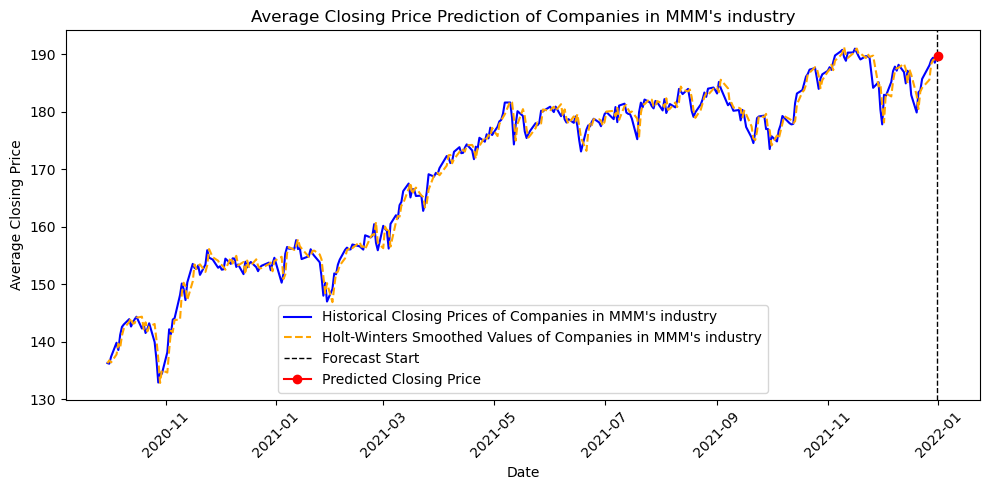

Predicted Average Closing Price for Companies in MMM's industry on the next day: 189.657489402048
RMSE between smoothed values and actual closing prices: 1.6740883322406683
MAPE between smoothed values and actual closing prices: 0.78%


In [56]:
# Forecast the next day's closing price
forecast = model.forecast(steps=1)

# Prepare data for visualization
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(avg_last_n_days.index, avg_last_n_days, label=f"Historical Closing Prices of Companies in {target_company}'s industry", color='blue')
plt.plot(smoothed_values.index, smoothed_values, label= f"Holt-Winters Smoothed Values of Companies in {target_company}'s industry", color='orange', linestyle='--')
plt.axvline(x=avg_last_n_days.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(avg_last_n_days.index[-1] + pd.DateOffset(days=1), forecast, marker='o', label=f'Predicted Closing Price', color='red')
plt.title(f"Average Closing Price Prediction of Companies in {target_company}'s industry")
plt.xlabel('Date')
plt.ylabel('Average Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f"Predicted Average Closing Price for Companies in {target_company}'s industry on the next day: {forecast.iloc[0]}")

# Calcualte RMSE between actual values and smoothed values
rmse = root_mean_squared_error(avg_last_n_days.values, smoothed_values.values)
print(f"RMSE between smoothed values and actual closing prices: {rmse}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((avg_last_n_days.values - smoothed_values.values) / avg_last_n_days.values)) * 100
print(f'MAPE between smoothed values and actual closing prices: {mape:.2f}%')


# Perform same operations on same company on TEST set (the target company)

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model wi

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  100
Model:             ExponentialSmoothing   SSE                            466.176
Optimized:                         True   AIC                            175.939
Trend:                   Multiplicative   BIC                            204.596
Seasonal:                      Additive   AICC                           180.172
Seasonal Periods:                     7   Date:                 Sun, 27 Oct 2024
Box-Cox:                          False   Time:                         21:19:30
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

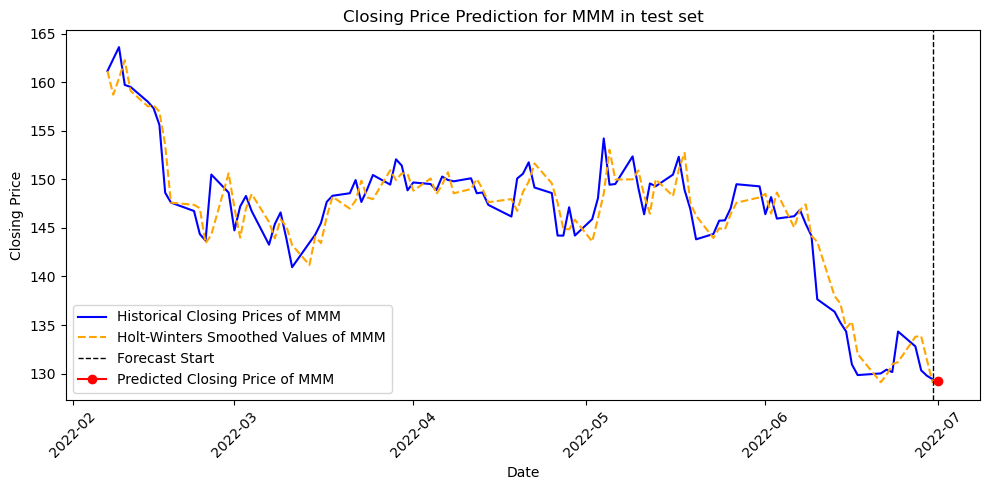

Predicted Closing Price for MMM on the next day: 129.26384814412614
RMSE between smoothed values and actual closing prices: 2.1591097954531384
MAPE between smoothed values and actual closing prices: 1.19%


In [57]:
# Load the dataset
test_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")

# Convert 'Date' to datetime
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Check for NaT values after conversion
if test_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(test_data[test_data['Date'].isnull()])

# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
test_target_company = 'MMM'

# Ensure company is in the dataset
if test_target_company not in test_data['Symbol'].unique():
    raise ValueError(f"{test_target_company} is not in the dataset.")

# Filter data for the target company and set 'Date' column as index
test_target_data = test_data[test_data['Symbol'] == test_target_company].set_index('Date')

# Ensure we have at least 5 days of data
if len(test_target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TEST YOUR MODEL HERE
# Take the last n days for modeling - we will take 100 days from test set
# Despite having avg in its name, it is not an average, but it is used to note that it is the test version of avg_last_days in training model
test_avg_last_n_days = test_target_data['Close'].tail(100)

# Ensure 'test_avg_last_n_days' is not empty
if test_avg_last_n_days.empty:
    raise ValueError("No closing price data available for modeling.")

# Fit the Holt-Winters model using trend, seasonal and seasonality obtained during training of other companies
test_model = ExponentialSmoothing(
    test_avg_last_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

print(test_model.summary())

# Forecast the next day's closing price
test_forecast = test_model.forecast(steps=1)

# Prepare data for visualization
test_smoothed_values = test_model.fittedvalues

# Calcualte RMSE between actual values and smoothed values
test_rmse = root_mean_squared_error(test_avg_last_n_days.values, test_smoothed_values.values)

# Calculate MAPE
test_mape = np.mean(np.abs((test_avg_last_n_days.values - test_smoothed_values.values) / test_avg_last_n_days.values)) * 100


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_avg_last_n_days.index, test_avg_last_n_days, label=f'Historical Closing Prices of {test_target_company}', color='blue')
plt.plot(test_smoothed_values.index, test_smoothed_values, label= f"Holt-Winters Smoothed Values of {test_target_company}", color='orange', linestyle='--')
plt.axvline(x=test_avg_last_n_days.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(test_avg_last_n_days.index[-1] + pd.DateOffset(days=1), test_forecast, marker='o', label=f'Predicted Closing Price of {test_target_company}', color='red')
plt.title(f'Closing Price Prediction for {test_target_company} in test set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f'Predicted Closing Price for {test_target_company} on the next day: {test_forecast.iloc[0]}')
print(f"RMSE between smoothed values and actual closing prices: {test_rmse}")
print(f'MAPE between smoothed values and actual closing prices: {test_mape:.2f}%')



# All companies in training set and all companies in test set

# Training set= all S&P 500 companies, including target company
# Define your company of interest and obtain the average closing price for the days in training set (n>= 5)

In [58]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
target_company = 'MMM'

# Ensure we have data for the target company
if target_company not in data['Symbol'].unique():
    raise ValueError(f"{target_company} is not in the dataset.")

# Filter data for the target company
target_data = data[data['Symbol'] == target_company].set_index('Date')

# Ensure we have enough data for the target company
if len(target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TRAIN YOUR MODEL HERE
# Take the last n days for modeling - we will use entire length of training set
last_n_days_target = target_data['Close']

# Get the last n days of data for all companies in the dataset
last_n_days_all = data[data['Date'].isin(last_n_days_target.index)]

# Calculate the average closing price for the last n days for all companies including the target company
avg_last_n_days_all = last_n_days_all.groupby('Date')['Close'].mean()


# Perform rolling-window cross validation

In [59]:
# Define rolling window parameters
n = len(avg_last_n_days_all)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1  # Use a smaller value like 1 for rolling windows

In [60]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = avg_last_n_days_all.iloc[:train_size + start]
    test = avg_last_n_days_all.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7) #weekly seasonality
            fit = model.fit()
            
            # Forecast the next value(s)
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast)  
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  1.482946
1   add      mul  1.493265
2   mul      add  1.481911
3   mul      mul  1.489159
Lowest RMSE: 1.4819105323029511
Trend: mul, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Us

# Input the trend and seasonal, that gives the lowest RMSE found during cross validation, into Holt-Winter's model

In [61]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    avg_last_n_days_all,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

print(model.summary())

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  317
Model:             ExponentialSmoothing   SSE                            829.291
Optimized:                         True   AIC                            326.849
Trend:                   Multiplicative   BIC                            368.197
Seasonal:                      Additive   AICC                           328.050
Seasonal Periods:                     7   Date:                 Sun, 27 Oct 2024
Box-Cox:                          False   Time:                         21:19:58
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9556761                alpha                 True
smoothing_trend          

# Forecast using model and visualise Holt-Winter's smoothed values, actual values and forecast

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


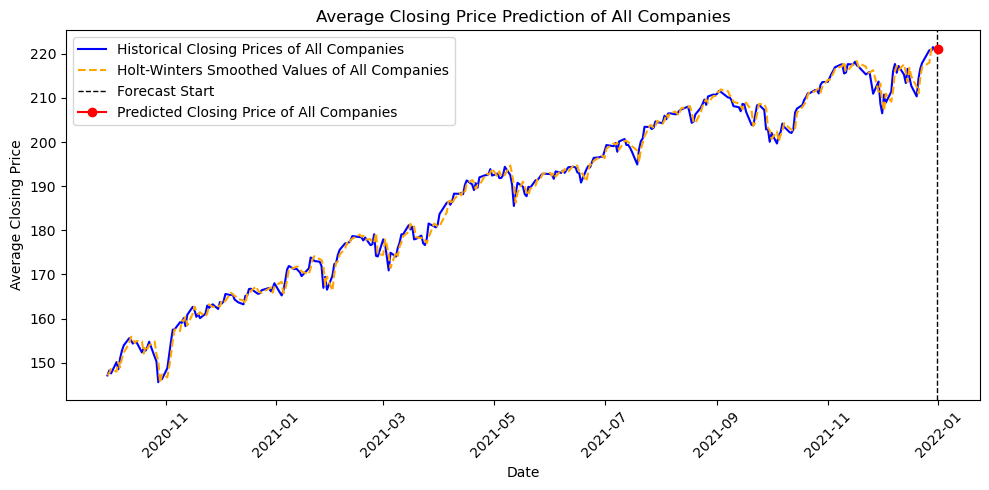

Predicted Average Closing Price for All Companies on the next day: 221.16098950357951
RMSE between smoothed values and actual closing prices: 1.61742344482224
MAPE between smoothed values and actual closing prices: 0.67%


In [64]:
# Forecast the next day's closing price
forecast = model.forecast(steps=1)

# Prepare data for visualization
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(avg_last_n_days_all.index, avg_last_n_days_all, label=f"Historical Closing Prices of All Companies", color='blue')
plt.plot(smoothed_values.index, smoothed_values, label= f"Holt-Winters Smoothed Values of All Companies", color='orange', linestyle='--')
plt.axvline(x=avg_last_n_days_all.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(avg_last_n_days_all.index[-1] + pd.DateOffset(days=1), forecast, marker='o', label=f'Predicted Closing Price of All Companies', color='red')
plt.title(f"Average Closing Price Prediction of All Companies")
plt.xlabel('Date')
plt.ylabel('Average Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f"Predicted Average Closing Price for All Companies on the next day: {forecast.iloc[0]}")

# Calcualte RMSE between actual values and smoothed values
rmse = root_mean_squared_error(avg_last_n_days_all.values, smoothed_values.values)
print(f"RMSE between smoothed values and actual closing prices: {rmse}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((avg_last_n_days_all.values - smoothed_values.values) / avg_last_n_days_all.values)) * 100
print(f'MAPE between smoothed values and actual closing prices: {mape:.2f}%')


# Perform same operations on TEST set

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model wi

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  100
Model:             ExponentialSmoothing   SSE                            466.176
Optimized:                         True   AIC                            175.939
Trend:                   Multiplicative   BIC                            204.596
Seasonal:                      Additive   AICC                           180.172
Seasonal Periods:                     7   Date:                 Sun, 27 Oct 2024
Box-Cox:                          False   Time:                         21:19:58
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

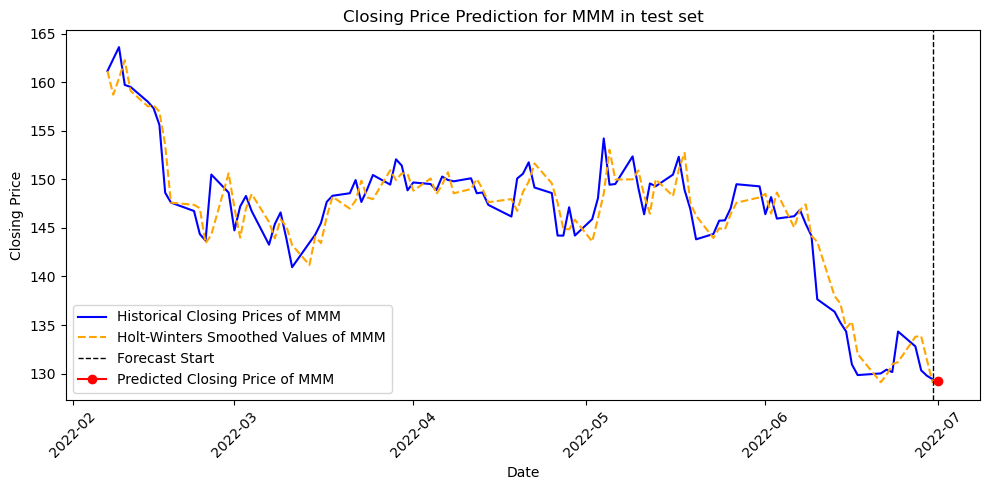

Predicted Closing Price for MMM on the next day: 129.26384814412614
RMSE between smoothed values and actual closing prices: 2.1591097954531384
MAPE between smoothed values and actual closing prices: 1.19%


In [63]:
# Load the dataset
test_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")

# Convert 'Date' to datetime
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Check for NaT values after conversion
if test_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(test_data[test_data['Date'].isnull()])

# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
test_target_company = 'MMM'

# Ensure company is in the dataset
if test_target_company not in test_data['Symbol'].unique():
    raise ValueError(f"{test_target_company} is not in the dataset.")

# Filter data for the target company and set 'Date' column as index
test_target_data = test_data[test_data['Symbol'] == test_target_company].set_index('Date')

# Ensure we have at least 5 days of data
if len(test_target_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TEST YOUR MODEL HERE
# Take the last n days for modeling - we will take 100 days from test set
# Despite having avg in its name, it is not an average, but it is used to note that it is the test version of avg_last_days_all in training model
test_avg_last_n_days_all = test_target_data['Close'].tail(100)

# Ensure 'test_avg_last_n_days_all' is not empty
if test_avg_last_n_days_all.empty:
    raise ValueError("No closing price data available for modeling.")

# Fit the Holt-Winters model using trend, seasonal and seasonality obtained during training of all companies
test_model = ExponentialSmoothing(
    test_avg_last_n_days_all,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7  # weekly seasonality
).fit()

print(test_model.summary())

# Forecast the next day's closing price
test_forecast = test_model.forecast(steps=1)

# Prepare data for visualization
test_smoothed_values = test_model.fittedvalues

# Calcualte RMSE between actual values and smoothed values
test_rmse = root_mean_squared_error(test_avg_last_n_days_all.values, test_smoothed_values.values)

# Calculate MAPE
test_mape = np.mean(np.abs((test_avg_last_n_days_all.values - test_smoothed_values.values) / test_avg_last_n_days_all.values)) * 100


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_avg_last_n_days_all.index, test_avg_last_n_days_all, label=f'Historical Closing Prices of {test_target_company}', color='blue')
plt.plot(test_smoothed_values.index, test_smoothed_values, label= f"Holt-Winters Smoothed Values of {test_target_company}", color='orange', linestyle='--')
plt.axvline(x=test_avg_last_n_days_all.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.plot(test_avg_last_n_days_all.index[-1] + pd.DateOffset(days=1), test_forecast, marker='o', label=f'Predicted Closing Price of {test_target_company}', color='red')
plt.title(f'Closing Price Prediction for {test_target_company} in test set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price
print(f'Predicted Closing Price for {test_target_company} on the next day: {test_forecast.iloc[0]}')
print(f"RMSE between smoothed values and actual closing prices: {test_rmse}")
print(f'MAPE between smoothed values and actual closing prices: {test_mape:.2f}%')

